In [13]:
# Imports
import sys
sys.path.append('./FDFD')
import numpy as np
import matplotlib.pylab as plt
from time import time
from solveFDFD import solveFDFD
from NN import NN
from IPython.display import clear_output
%matplotlib inline

In [53]:
# Define Parameters
pol = 'TM'
timing = True
L0 = 1e-6
wvlen = 0.55
xrange = [-1, 1]
yrange = [-1, 1]
Nx = 80
Ny = 80
L_box = 30
H_box = 30
eps = 5
npml = 10

In [54]:
layer_sizes = [2,40,40,40,40,40,1]
activations = ['tanh','tanh','tanh','tanh','tanh','sigmoid']

In [55]:
# Set Up Simulation Variables
nx = int(Nx//2)
ny = int(Ny//2)
src_pos_og_x = nx-npml#int((Nx/2.0-L_box/2.0-npml)//2) + npml
#src_pos_og_x = npml+10
src_pos_aj_x = Nx - src_pos_og_x
src_pos_og_y = ny-npml#int((Ny/2.0-H_box/2.0-npml)//2) + npml
#src_pos_og_y = npml+10
src_pos_aj_y = Ny - src_pos_og_y

eps_r = np.ones((Nx,Ny))
eps_r[nx-int(L_box//2):nx+int(L_box//2), ny-int(H_box//2):ny+int(H_box//2)] = eps
SRC_og = np.zeros((Nx,Ny))
SRC_aj = np.zeros((Nx,Ny))
SRC_aj[src_pos_aj_x,src_pos_og_y:src_pos_aj_y] = 1
SRC_aj[src_pos_og_x,src_pos_og_y:src_pos_aj_y] = 1
SRC_aj[src_pos_og_x:src_pos_aj_x,src_pos_og_y] = 1
SRC_aj[src_pos_og_x:src_pos_aj_x,src_pos_aj_y] = 1
SRC_og[nx,ny] = 1
SRC_aj = np.zeros((Nx,Ny))
SRC_aj[20,20] = 1

Npml = [npml,npml,npml,npml]
delta_device = 1.*(eps_r>1)

k0 = 2*np.pi/wvlen
x_points = np.linspace(xrange[0],xrange[1],Nx)
y_points = np.linspace(yrange[0],yrange[1],Ny)
training_examples = np.zeros((2,Nx*Ny))
iteration = 0
for i in range(Nx):
    for j in range(Ny):
        training_examples[0,iteration] = x_points[i]
        training_examples[1,iteration] = y_points[j]
        iteration += 1        

In [56]:
ny

40

In [52]:
neuralNet = NN(layer_sizes,activations)
_ = neuralNet.derivative_check()
Js = []
timing = False
learning_rate = .01
skip = 10
N_iterations = 100000
for i in range(N_iterations):
    A = neuralNet.forward_prop(training_examples)
    dAdZ = A*(1-A)
    eps_r_vec = (eps-1.)*A+1.
    eps_r = delta_device*np.reshape(eps_r_vec,(Nx,Ny)) + (1-delta_device)
    # Do original simulation and adjoint simulation
    (_, _, Ez_og, Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_og, Npml, timing=timing)
    meas = np.sum(Ez_og.T*SRC_aj)
    J = abs(meas)**2
    Js.append(J)
    #print(Js)
    #plt.imshow(eps_r.T)
    #plt.show()
    (_, _, Ez_aj, Hx_aj, Hy_aj, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_aj, Npml, timing=timing)
    dJde_aj = (k0**2)*(np.real(1j*np.conj(meas)*Ez_og*Ez_aj).T)*delta_device
    
    dedA = (eps-1.)
    neuralNet.back_prop(np.reshape(dJde_aj,(1,Nx*Ny))*dedA*dAdZ)
    neuralNet.update_weights(learning_rate=learning_rate)
    if i%skip == 0:
        clear_output()
        f, axarr = plt.subplots(1, 4, figsize=(15,5))
        axarr[0].plot(Js[0:i])
        axarr[0].set_title('objective function')
        axarr[1].imshow(eps_r.T,clim=(0.9, eps+0.1))
        axarr[1].set_title('permittivity')
        axarr[2].imshow(np.power(np.abs(Ez_og),1))
        axarr[2].set_title('original field')
        axarr[3].imshow(np.real(Ez_aj))
        axarr[3].set_title('adjoint field')
        f.subplots_adjust(hspace=0.3)    
        plt.show()

KeyboardInterrupt: 

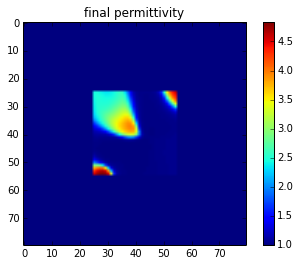

In [35]:
plt.imshow(eps_r)
plt.colorbar()
plt.title('final permittivity')
plt.savefig('./figures/eps_optimization.pdf')

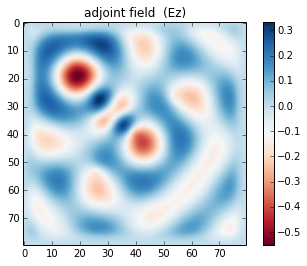

In [44]:
plt.imshow(np.real(np.reshape(Ez_aj,(Nx,Ny))),cmap='RdBu')
plt.title('adjoint field  (Ez)')
plt.colorbar()
plt.savefig('./figures/adjoint_optimization.pdf')

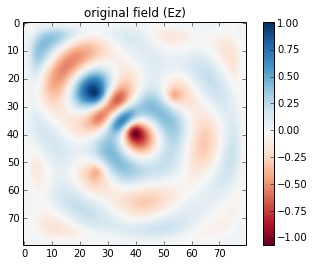

In [45]:
plt.imshow(np.real(np.reshape(Ez_og,(Nx,Ny))),cmap='RdBu')
plt.colorbar()
plt.title('original field (Ez)')
plt.savefig('./figures/original_optimization.pdf')

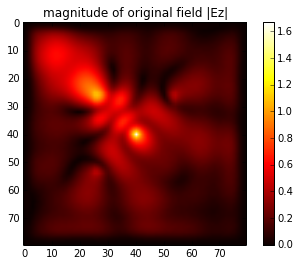

In [46]:
plt.imshow(np.abs(np.reshape(Ez_og,(Nx,Ny))),cmap='hot')
plt.colorbar()
plt.title('magnitude of original field |Ez|')
plt.savefig('./figures/mag_optimization.pdf')

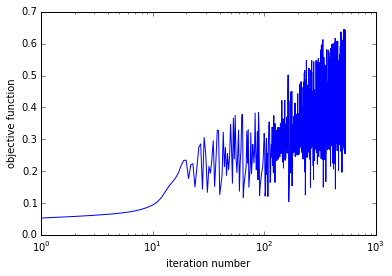

In [39]:
plt.semilogx(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.savefig('./figures/Js_optimization.pdf')

In [ ]:
Js = []
adjoints = []
numericals = []
N_wvl = 20
epsilon = 1e-5
wvlens = np.linspace(1.5,1.6,N_wvl)
for i in range(N_wvl):
    wvlen = wvlens[i]
    k0 = 2*np.pi/wvlen
    eps_r = (eps-1)*delta_device + 1
    (_, _, Ez_og, Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_og, Npml, timing=timing)
    meas = np.sum(Ez_og.T*SRC_aj)
    J = abs(meas)**2
    Js.append(J)
    print(J)
    (_, _, Ez_aj, Hx_aj, Hy_aj, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_r, SRC_aj, Npml, timing=timing)
    dJde_aj = -k0**2*np.sum((np.real(1j*np.conj(meas)*Ez_og*Ez_aj).T)*delta_device)
    adjoints.append(dJde_aj)
    eps_plus = (eps+epsilon-1.)*delta_device + 1.
    eps_minus = (eps-epsilon-1.)*delta_device + 1.
    (_, _, Ez_plus,  Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_plus,  SRC_og, Npml, timing=timing)
    (_, _, Ez_minus, Hx_og, Hy_og, _, _) = solveFDFD(pol, L0, wvlen, xrange, yrange, eps_minus, SRC_og, Npml, timing=timing)
    J_plus  = abs(np.sum(Ez_plus.T*SRC_aj))**2
    J_minus = abs(np.sum(Ez_minus.T*SRC_aj))**2    
    numericals.append((J_plus-J_minus)/(2*epsilon))

In [ ]:
plt.plot(adjoints)
plt.plot([-750*i for i in numericals])
plt.show()

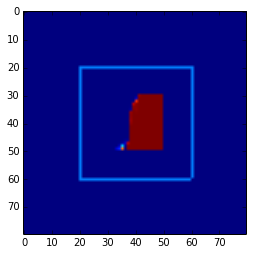

In [17]:
plt.imshow(np.real(SRC_aj)+eps_r)
plt.show()